## Import necessary modules

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import datetime
import ipywidgets as widgets
from ipywidgets import *
from datetime import *
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
from matplotlib import style, scale
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
import mplcursors
from IPython.display import clear_output
%matplotlib nbagg

## Identify large global indexes, and define widgets to be used later

In [11]:
indx_lst = ["S&P 500", "Dow 30", "Nasdaq", "VIX", "DAX", "Hang Seng Index", "FTSE 100", "Nikkei 225"]
inter_lst = ["1min", "5min", "15min", "30min", "60min", "daily", "weekly", "monthly" ]

index_select = widgets.Dropdown(        #Dropdown list with options for major global indexes
    options= indx_lst,
    value= indx_lst[0],
    description= 'Select Index: ',
    disabled=False,
    layout={'width': '25%'},
    style={'description_width': 'max-content'}
)

interval_select = widgets.Dropdown(     #Dropdwon list with options for desired interval
    options = inter_lst,
    value= inter_lst[0],
    description= 'Select Interval: ',
    disabled=False,
    layout={'width': 'max-content'},
    style={'description_width': 'max-content'}
)

prior_int = widgets.IntText(
    value = 100,
    min=0,
    max=250,
    step=1,
    description='Periods:',
    disabled=False,
    layout={'max_width': '150px'},
    style={'description_width': 'max-content'}    
)

custom_tckr = widgets.Text(
    value = "",
    description = "Other Symbol:",
    disabled=False,
    layout={'width': '20%'},
    style={'description_width': 'max-content'}
)

pct_change = widgets.ToggleButton(
    value=False,
    description = "% Change",
    disabled=False,
    button_style='',
    tooltip='Descrtiption',
    icon='check',
    layout={'width': '12%'},
)

button = widgets.Button(description="Collect Data",
                        layout={'width': '10%'}
                       )
output = widgets.Output

def on_click(b):
    if custom_tckr.value != '':
        symbol = custom_tckr.value.upper()
    else:
        symbol = ident_tick(index_select.value)

    interval = interval_select.value
    
    periods = prior_int.value
    
    change_TF = pct_change.value
    
    macd, macd_meta = get_MACD(symbol, interval)

    data, macd, xs, x_data = get_price(symbol, interval, macd, periods, steps=4)

    plot_prices(symbol, interval, data, macd, xs, x_data, Change=change_TF)
    
    display(data.head(), data.tail())

button.on_click(on_click)
        
items = [index_select, custom_tckr, interval_select, prior_int, pct_change, button]

box_layout = Layout(display='flex',
                    flex_flow='row',
                    align_items='stretch',
                    width='100%')
box_auto = Box(children=items, layout=box_layout)
a= VBox([box_auto])

## Define function to identify tickers

In [3]:
indx = index_select.value
intr = interval_select.value
tckr = ''

In [4]:
def ident_tick(str):
    symbol = ''
    
    if str == "S&P 500":
        symbol = "^GSPC"

    elif str == "Dow 30":
        symbol = "^DJI"

    elif str == "Nasdaq":
        symbol = "^IXIC"

    elif str == "VIX":
        symbol = "^VIX"

    elif str == "DAX":
        symbol = "^GDAXI"

    elif str == "Hang Seng Index":
        symbol = "^HSI"

    elif str == "FTSE 100":
        symbol = "^FTSE"

    elif str == "Nikkei 225":
        symbol = "^N225"
    
    return symbol

## Define fucntion to retrieve MACD data

In [5]:
ti = TechIndicators(key='V4NUY7N5VID4YGYP', output_format='pandas')
def get_MACD(symbol, interval, series_type='close', fast=12, slow=26, signal=9):
    macd, macd_meta = ti.get_macd(symbol= symbol,
                              interval= interval,
                              series_type= series_type,
                              fastperiod= fast,
                              slowperiod= slow,
                              signalperiod= signal)
    
    return macd, macd_meta

## Define function to retrieve live price data

In [19]:
# initialize TI & TS object with API key and output format
ts = TimeSeries(key='V4NUY7N5VID4YGYP', output_format='pandas')

def get_price(symbol, 
              interval, 
              macd,
              periods,
              steps=8):
    if interval not in ["daily", "weekly", "monthly"]:
        data, meta_data = ts.get_intraday(symbol=symbol,interval=interval, outputsize='full')
    
    elif interval == "daily":
        data, meta_data = ts.get_weekly_adjusted(symbol=symbol)
        
    elif interval == "weekly":
        data, meta_data = ts.get_weekly_adjusted(symbol=symbol)
        
    elif interval == "monthly":
        data, meta_data = ts.get_monthly_adjusted(symbol=symbol)
        
    data.rename(columns = {'1. open':'Open',
                           '2. high':'High',
                           '3. low' :'Low',
                           '4. close':'Close',
                           '5. adjusted close':'Adjusted Close',
                           '5. volume':'Volume'}, 
                           inplace=True)
    
    data = data.iloc[:,:4]
    data = data.join(macd)
    data = data[-periods:]
    data = data.reset_index()
    
    xs = [i for i in range(0, data.shape[0], int(data.shape[0]/steps))]       #Find incremental dates/times indexes for xaxis
    xs.append(data.shape[0])
    
    if interval in ["15min", "30min", "60min", "daily", "weekly", "monthly"]: #Find corresponding dates/times
        x_data = [data.date.iloc[i].date() for i in range(0, data.shape[0], int(data.shape[0]/steps))]
        x_data.append(data.date.iloc[-1].date())
    else:
        x_data = [data.date.iloc[i].time() for i in range(0, data.shape[0], int(data.shape[0]/steps))]
        x_data.append(data.date.iloc[-1].time())
        
    return data, macd, xs, x_data

## Define function to create figure with two subplots of `Prices OR % Change` and `MACD`

In [39]:
def plot_prices(symbol, interval, data, macd, xs, x_data, Change=False):
    %matplotlib nbagg
    
    style.use('bmh')                                      #Define styles to use
    plt.style.use(['dark_background'])
    
    fig = plt.figure(figsize=(9,6))                       #Create figure and gridspec objects
    gs = gridspec.GridSpec(3,1)
    
    ax0 = fig.add_subplot(gs[:2,0])                       #Create axis object that takes up 2/3 of figure
    ax0.set_yticks([])                                    #Shift y axis labels to RHS
    ax1 = ax0.twinx()                       
    
    symbol = symbol.replace('^','')
    
    if Change == False:
        plt.title(f"{symbol} {interval} Prices & MACD")       #In future versions, replace `MACD` with `indicator`
        line = plt.plot(data.index,                       #Plot the prices in axis object
                        data.Close, 
                        c='w', 
                        label=f"{symbol} Close", 
                        ls="-"
                       )
        ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
        
    elif Change == True:
        plt.title(f"{symbol} {interval} % Change & MACD")       #In future versions, replace `MACD` with `indicator`
        line = plt.plot(data.index,
                        data.Close.pct_change()*100,
                        c='w',
                        label=f"{symbol} Close % Change",
                        ls="-"
                        )
        ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.axhline(y=0, c='grey')

    plt.legend()
    plt.grid(b=None,which='both',axis='y')
    
    ax1.set_xticks(xs)                                    #Match up x ticks with bottom axis object
    ax1.set_xticklabels([])
    
    if interval in ["15min", "30min", "60min", "daily", "weekly", "monthly"]:
        plt.xticks(rotation=30)
        
    ax2 = fig.add_subplot(gs[2,0])                        #Create second axis object that takes up bottom 1/3 of figure
    ax2.set_yticks([])
    ax3 = ax2.twinx()
    
    plt.bar(data.index,                                   #Plot MACD histogram as yellow bars
            data.MACD_Hist, 
            color='y', 
            label= "MACD_Hist")
    
    plt.plot(data.index,                                  #Plot the MACD as red line
             data.MACD, 
             c='r', 
             label= "MACD")
    
    plt.plot(data.index,                                  #Plot the MACD signal as blue line
         data.MACD_Signal, 
         c='b', 
         label= "MACD Signal")
   
    ax3.axhline(y=0, c='grey')

    ax3.set_xlim(ax1.get_xlim())
    ax3.set_xticks(xs)                                    #Match up x ticks with top plot, add labels  
    ax3.set_xticklabels(x_data)
    if intr in ["15min", "30min", "60min", "daily", "weekly", "monthly"]:
        plt.xticks(rotation=-30)

    gs.update(wspace=0.5, hspace=0.0)                     #Line up bottom and top of axis objects
    plt.legend()
    
    mplcursors.cursor(hover=True)
    plt.show()

## Identify `index` and `interval` to analyze

<IPython.core.display.Javascript object>


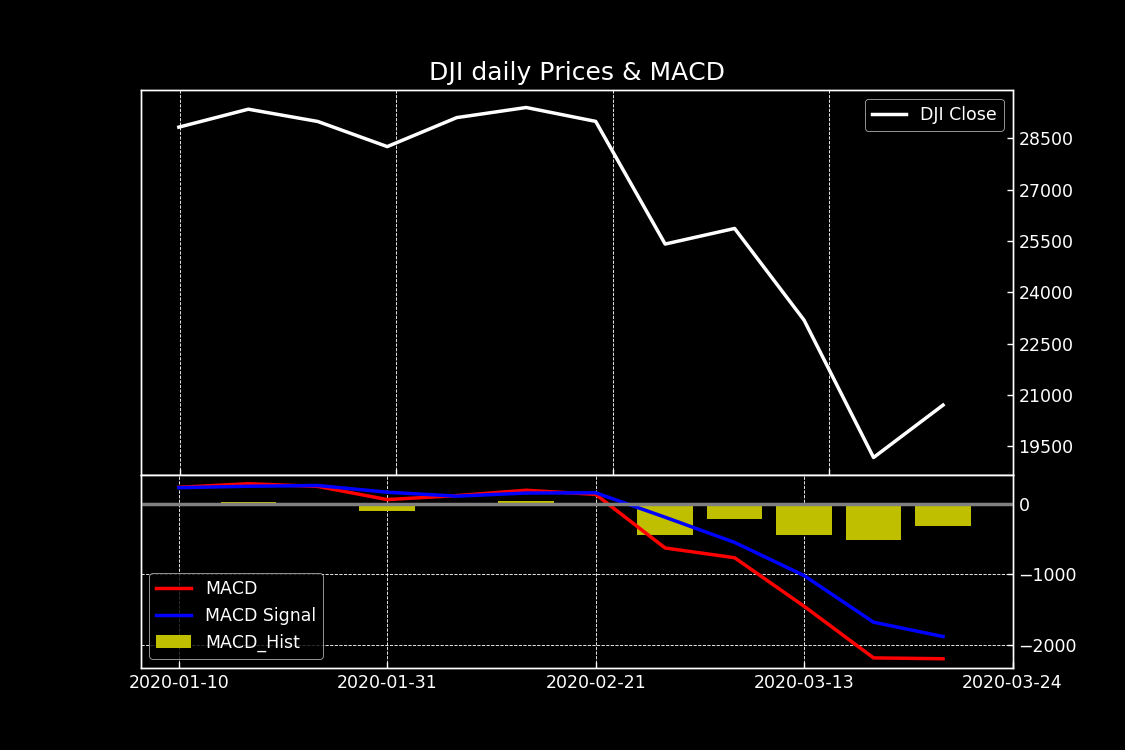

,date,Open,High,Low,Close,MACD,MACD_Hist,MACD_Signal
0,2020-01-10,28465.5000,29009.0703,28418.6309,28823.7695,238.0402,5.1860,232.8542
1,2020-01-17,28869.0098,29373.6191,28819.4297,29348.0996,288.7250,35.5115,253.2135
2,2020-01-24,29269.0508,29341.2109,28843.3105,28989.7305,250.9637,-12.6827,263.6464
3,2020-01-31,28542.4902,28944.2402,28169.5293,28256.0293,63.3304,-104.8541,168.1845
4,2020-02-07,28319.6504,29408.0508,28319.6504,29102.5098,119.6673,7.5879,112.0795


,date,Open,High,Low,Close,MACD,MACD_Hist,MACD_Signal
7,2020-02-28,28402.9297,28402.9297,24681.0098,25409.3594,-625.4780,-437.6855,-187.7925
8,2020-03-06,25590.5098,27102.3398,25226.6191,25864.7793,-764.3836,-218.1885,-546.1952
9,2020-03-13,24992.3594,25020.9902,21154.4609,23185.6191,-1454.6797,-436.4960,-1018.1837
10,2020-03-20,20917.5293,21768.2793,18917.4609,19173.9805,-2189.8415,-507.8810,-1681.9605
11,2020-03-24,19028.3594,20737.6992,18213.6504,20704.9102,-2201.9698,-316.1794,-1885.7905


In [40]:
a